In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install tensorflow
# !pip install loguru
# !pip install opencv_python

In [3]:
import numpy as np
# import cv2, os, shutil, dlib, glob, os.path, random, math, PIL, PIL.Image
# from loguru import logger as log
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Model, Sequential
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Processing

- set path to dataset
- prepare dataset batches
- create train and test batches
- preprocess images


In [4]:
#Constants
VERSION='_final_284k'

BATCH_SIZE = 250

HEIGHT = 20
WIDTH = 20
CHANNEL =1
IMG_SIZE = (HEIGHT,WIDTH)

EPOCH = 100

VAL_SPLIT= 0.20
TRAIN_SPLIT = 0.80

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(4, 6)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

## Prepare Datasets


In [5]:
train_path= "/kaggle/input/human-eyes-openclose-tipe/train"
test_path= "/kaggle/input/human-eyes-openclose-tipe/test"


In [6]:
train_ds = image_dataset_from_directory(directory=train_path,
                                          color_mode='grayscale',image_size=IMG_SIZE,
                                          class_names=["open eyes", "close eyes"], validation_split=0.2,
                                        subset="training",seed=16,
                                          batch_size=BATCH_SIZE, shuffle=True )

validation_ds = image_dataset_from_directory(directory=train_path,color_mode='grayscale',image_size=IMG_SIZE,
                                          class_names=["open eyes", "close eyes"], validation_split=0.2,
                                        subset="validation", seed=16,
                                          batch_size=BATCH_SIZE, shuffle=True )

test_ds = image_dataset_from_directory(directory=test_path,color_mode='grayscale',image_size=IMG_SIZE,
                                          class_names=["open eyes", "close eyes"],
                                          batch_size=BATCH_SIZE)


Found 59972 files belonging to 2 classes.
Using 47978 files for training.
Found 59972 files belonging to 2 classes.
Using 11994 files for validation.
Found 24926 files belonging to 2 classes.


In [7]:
# ds_len  = ds.reduce(0, lambda x, _: x + 1).numpy()
# validation_ds_size = int(VAL_SPLIT * ds_len)
# train_ds_size = int(TRAIN_SPLIT* ds_len)

# train_ds = ds.take(train_ds_size)

# validation_ds = ds.skip(train_ds_size).take(validation_ds_size)

dataset class names ['open eyes', 'close eyes']


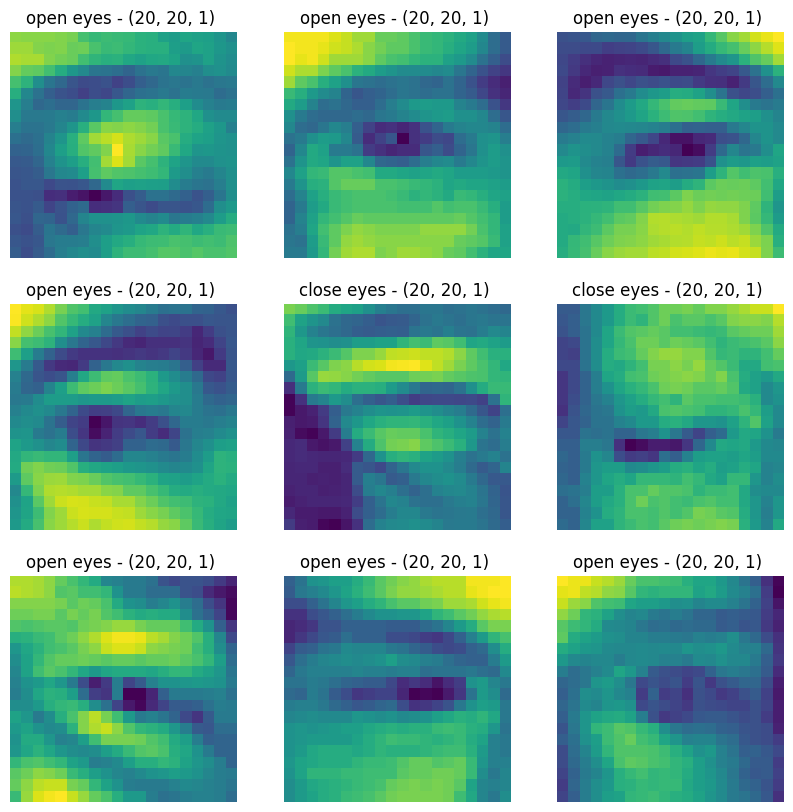

In [8]:
class_names = train_ds.class_names
print(f"dataset class names {class_names}")


## quick plot to see if the data were labeled properly
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{class_names[labels[i]]} - {images[i].shape} ")
    plt.axis("off")

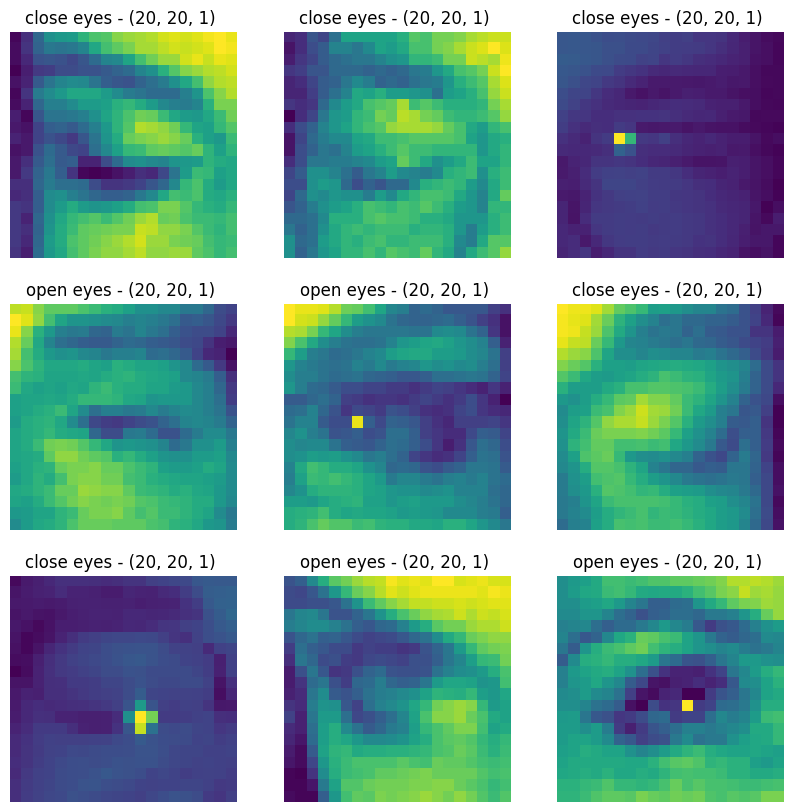

In [9]:

## quick plot to see if the data were labeled properly
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{class_names[labels[i]]} - {images[i].shape} ")
    plt.axis("off")

## Modelling


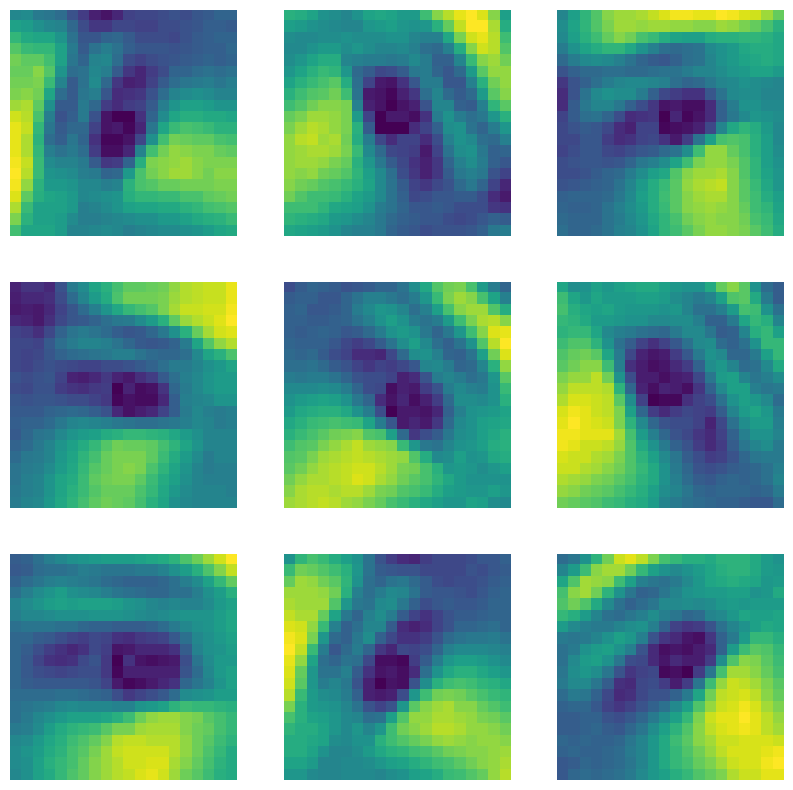

In [10]:
num_classes = len(class_names)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(HEIGHT,WIDTH),
  layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal', input_shape = (HEIGHT,WIDTH, CHANNEL)),
  layers.RandomZoom(0.2),layers.RandomRotation(0.2)
])

stacked_preprocessors = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,

    ])

# sample augemented image
plt.figure(figsize=(10, 10))
for image, lab in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



In [11]:
model = Sequential([
  Input(shape=(HEIGHT,WIDTH, CHANNEL)),
  layers.Resizing(HEIGHT,WIDTH),
  layers.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
    layers.MaxPooling2D(strides = 2),
  layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
    layers.MaxPooling2D(strides = 2),
#   layers.BatchNormalization(),
#   layers.Dropout(0.3),

#   layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
#   layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(strides = 2),
# #   layers.Dropout(0.3),

  layers.Flatten(),
#   layers.Dense(units  = 256, activation = 'relu', use_bias=False),
#   layers.BatchNormalization(),

  layers.Dense(units = 32, use_bias=False, activation = 'relu'),

#   layers.Dense(units = 16, use_bias=False, activation = 'relu'),
#   layers.BatchNormalization(),
#   layers.Dropout(0.3),

  layers.Dense(num_classes, name='out', activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 20, 20, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 20, 20, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 20, 20, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                      

In [12]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)

In [13]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCH, 
                    validation_data=validation_ds, shuffle=True,callbacks=callback )


Epoch 1/100
192/192 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6836
Epoch 1: val_loss improved from inf to 0.44319, saving model to bestModel.h5
192/192 [==============================] - 149s 736ms/step - loss: 0.5891 - accuracy: 0.6836 - val_loss: 0.4432 - val_accuracy: 0.8346
Epoch 2/100
192/192 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8485
Epoch 2: val_loss improved from 0.44319 to 0.34418, saving model to bestModel.h5
192/192 [==============================] - 26s 133ms/step - loss: 0.4016 - accuracy: 0.8485 - val_loss: 0.3442 - val_accuracy: 0.8705
Epoch 3/100
192/192 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8723
Epoch 3: val_loss improved from 0.34418 to 0.29623, saving model to bestModel.h5
192/192 [==============================] - 30s 149ms/step - loss: 0.3371 - accuracy: 0.8723 - val_loss: 0.2962 - val_accuracy: 0.8855
Epoch 4/100
192/192 [==============================] - ETA: 0s - lo

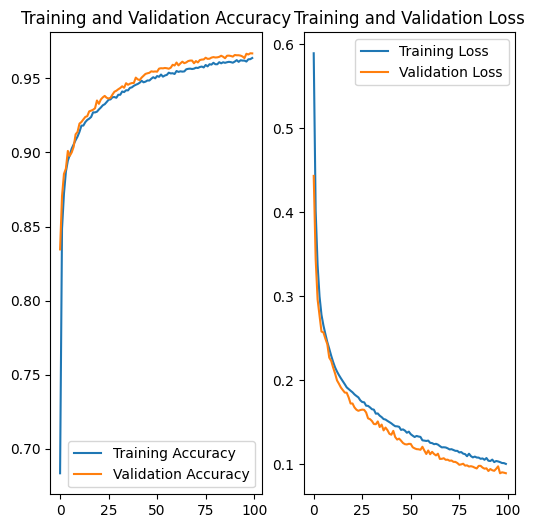

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
from keras.models import load_model
best_model = load_model('/kaggle/working/bestModel.h5')

In [16]:
# actual = [labels for _, labels in test_ds.unbatch()]
# predicted = best_model.predict(test_ds)

# actual = tf.stack(actual, axis=0)
# predicted = tf.concat(predicted, axis=0)
# predicted = tf.argmax(predicted, axis=1)


unbatched = [(img,labels) for img, labels in test_ds.unbatch().as_numpy_iterator()]

# test_img= [tf.expand_dims(img, 0) for  img, _ in test_ds.unbatch().as_numpy_iterator()]
predicted = []
actual_value= []
for img , actual in unbatched:
    predicted.append(model.predict(tf.expand_dims(img, 0) , verbose=0))
    actual_value.append(actual)
# predicted = np.array(predicted).flatten()
# predicted = (predicted > 0.5).astype(np.int32)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)



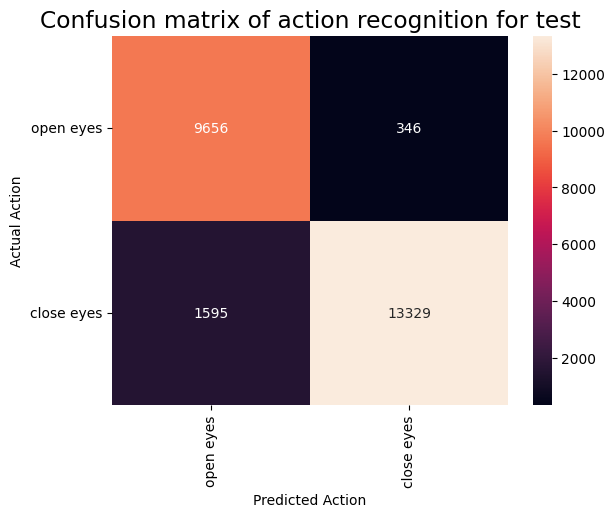

In [17]:
plot_confusion_matrix(actual=np.array(actual_value), predicted=np.array(predicted), labels=test_ds.class_names, ds_type='test' )

In [18]:
print(classification_report(np.array(predicted), np.array(actual_value)))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     11251
           1       0.89      0.97      0.93     13675

    accuracy                           0.92     24926
   macro avg       0.93      0.92      0.92     24926
weighted avg       0.93      0.92      0.92     24926



In [19]:
best_weights = best_model.get_weights()
weight_file = f'/kaggle/working/models/model2_tf_weight_{VERSION}'
model.save_weights( weight_file)


In [20]:
model_file = f'/kaggle/working/models/kaggle_best_model_{VERSION}.h5'
best_model.save(model_file)

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
tflite_file = f'/kaggle/working/models/kaggle_best_model_{VERSION}.tflite'


with open(tflite_file, 'wb') as f:
  f.write(tflite_model)